In [3]:
import tensorflow as tf
import keras
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

In [4]:
np.random.seed(4)

def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

生成三维数据

In [8]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [12]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

# 自动编码器

In [6]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [9]:
tf.random.set_seed(42)
np.random.seed(42)

# 编码器和解码器
stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])

# 训练集的x和y是同一个，因为要模仿自己
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 17s 8ms/step - loss: 0.3355 - rounded_accuracy: 0.8894 - val_loss: 0.3204 - val_rounded_accuracy: 0.8910
Epoch 2/20
1719/1719 [==============================] - 12s 7ms/step - loss: 0.3046 - rounded_accuracy: 0.9161 - val_loss: 0.3027 - val_rounded_accuracy: 0.9215
Epoch 3/20
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2972 - rounded_accuracy: 0.9229 - val_loss: 0.2959 - val_rounded_accuracy: 0.9242
Epoch 4/20
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2931 - rounded_accuracy: 0.9266 - val_loss: 0.2924 - val_rounded_accuracy: 0.9292
Epoch 5/20
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2905 - rounded_accuracy: 0.9288 - val_loss: 0.2912 - val_rounded_accuracy: 0.9287
Epoch 6/20
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2887 - rounded_accuracy: 0.9304 - val_loss: 0.2892 - val_rounded_accuracy: 0.9317
Epoch 7/20
1719/1719 [=============

对比原图和自动编码器生成图

In [10]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

1/1 [==============================] - 0s 15ms/step


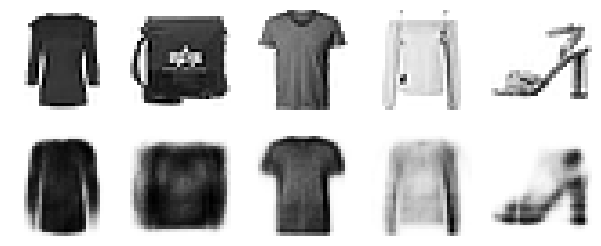

In [13]:
show_reconstructions(stacked_ae)

还有其他类型编码器，这里不详细写

# GAN

画图函数

In [19]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

In [14]:
np.random.seed(42)
tf.random.set_seed(42)

codings_size = 30

# GAN模型，一个生成器和一个判别器
generator = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[codings_size]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

In [15]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop") 
# 判别器在编译时默认设定为可训练，而在GAN中不需训练
discriminator.trainable = False # 设定不可训练，以便在下面编译GAN中判别器不会被训练
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [16]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000) # 打乱数据
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1) 
# 用tf.data.prefetch()方法，提前从数据集中取出若干数据放到内存中
# 这样可以使在gpu计算时，cpu通过处理数据，从而提高训练的速度

In [17]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))
        for X_batch in dataset:
            
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size]) # 生成随机噪声数据矩阵
            generated_images = generator(noise) # 利用生成器生成噪声图
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0) # 噪声+真图
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size) # 噪声标记为0，真图1
            discriminator.trainable = True # 前面在编译时候设定为不可训练，这里改成可训练以避免警告
            discriminator.train_on_batch(X_fake_and_real, y1) # fit也可以（？）
            
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size) # 我们希望让判别器认为生成器生成的图像都是真实图像
            discriminator.trainable = False 
            # 训练GAN时判别器不可训练，但前面设为True，这里设定False避免报错
            gan.train_on_batch(noise, y2)
        plot_multiple_images(generated_images, 8) # 此函数看图像
        plt.show()

怎么理解生成器设定y都是1（预测真）？因为生成器首先生成图像，第一次输出肯定是比较糟糕的，判别器就认为是伪，输出0，而真实值是1，进行反向传播时，这个误差先流到判别器，然而判别器不可训练，因此再流到生成器改变权重，使生成器的权重越来越靠近生成真实图的状态，要使误差变小，生成器就应该调整权重让图像更真实，从而骗过判别器，这就是GAN的基本思想。

判别器越好，生成器的进步空间就越大

Epoch 1/10


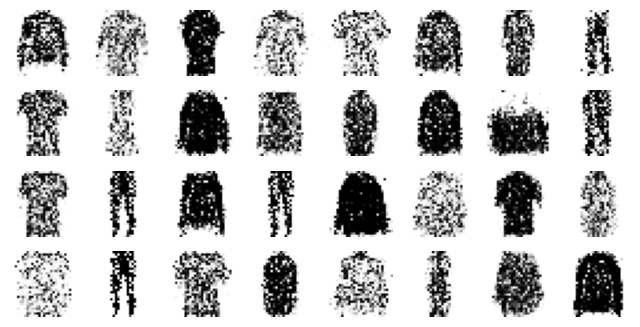

Epoch 2/10


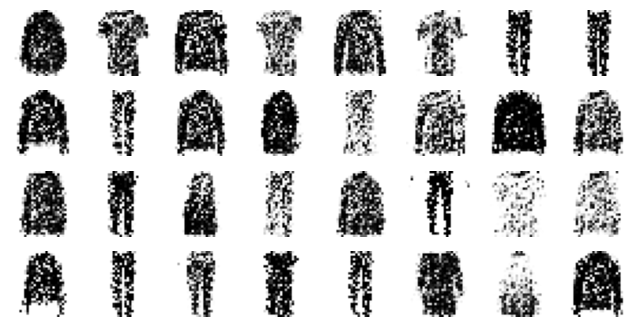

Epoch 3/10


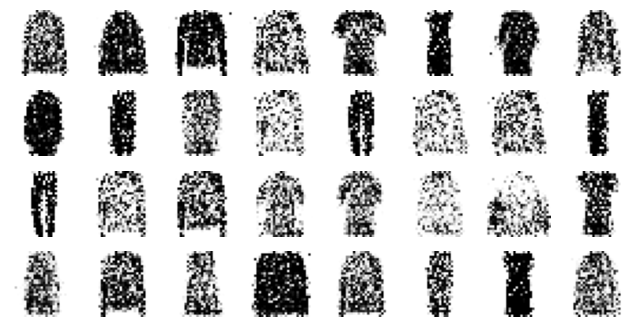

Epoch 4/10


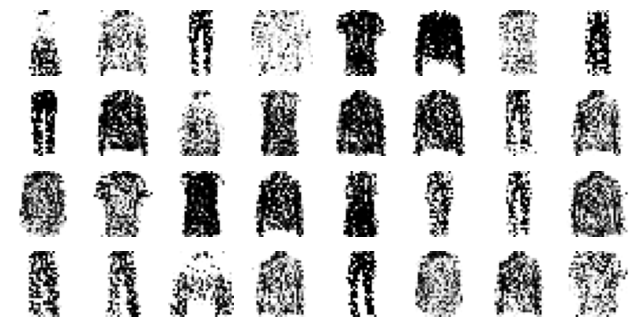

Epoch 5/10


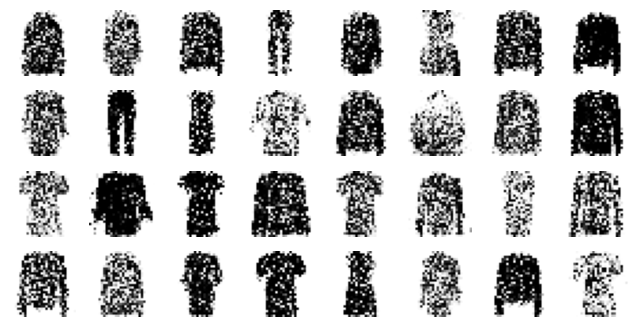

Epoch 6/10


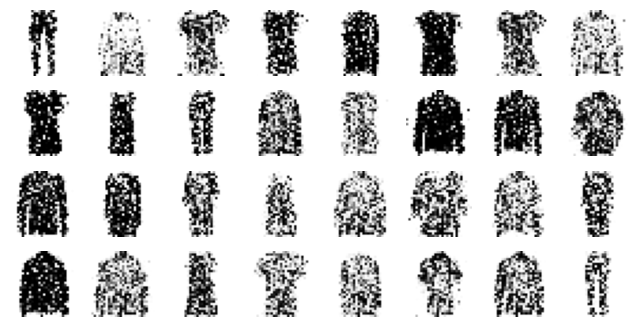

Epoch 7/10


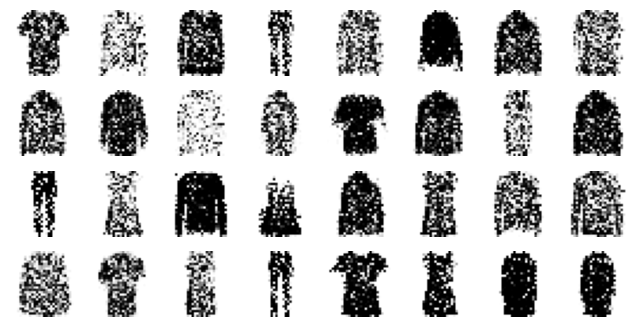

Epoch 8/10


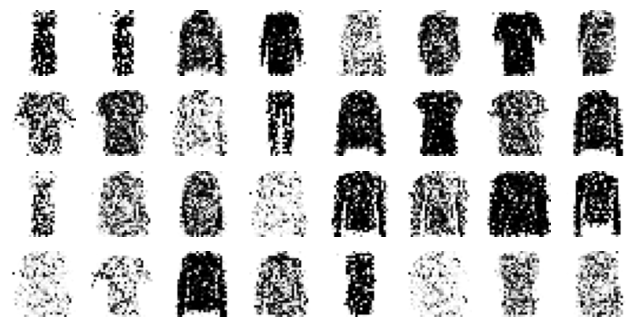

Epoch 9/10


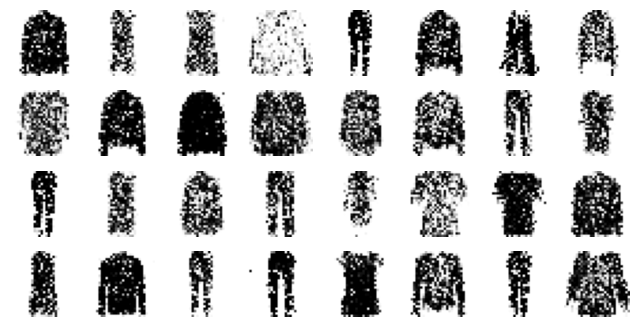

Epoch 10/10


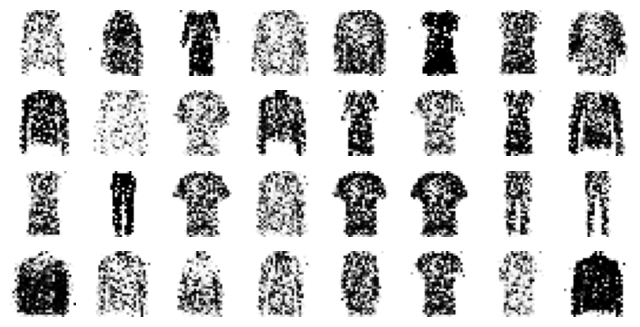

In [21]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=10)

# 深度卷积GAN（DCGAN）

In [23]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 100

generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape=[codings_size]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME",
                                 activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="SAME",
                                 activation="tanh"),
])
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[28, 28, 1]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

In [24]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [25]:
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1. # reshape and rescale

In [26]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

Epoch 1/10


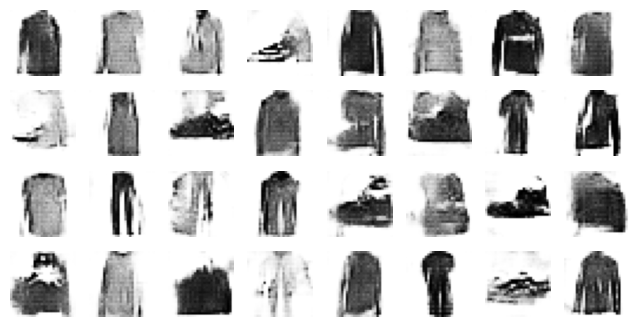

Epoch 2/10


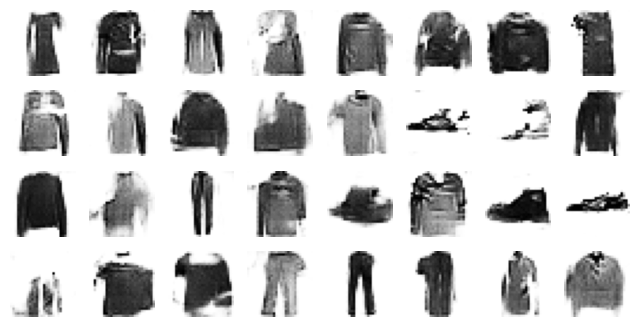

Epoch 3/10


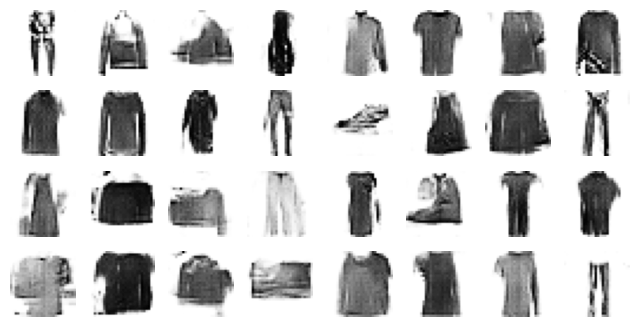

Epoch 4/10


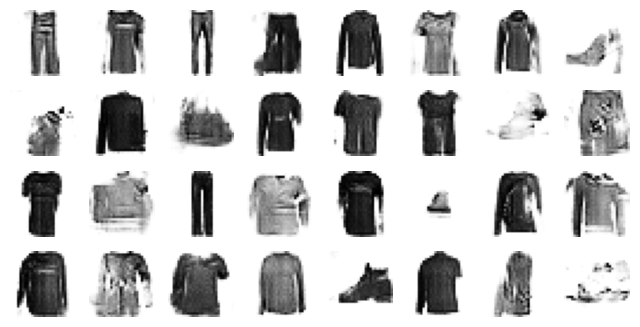

Epoch 5/10


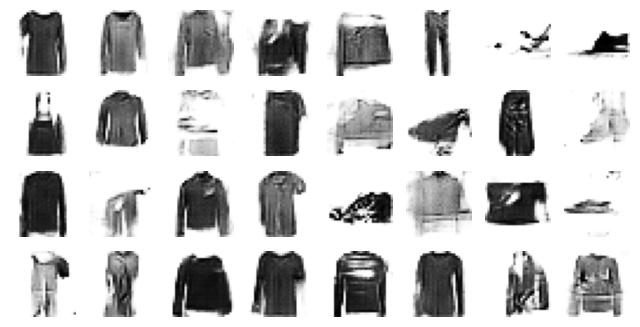

Epoch 6/10


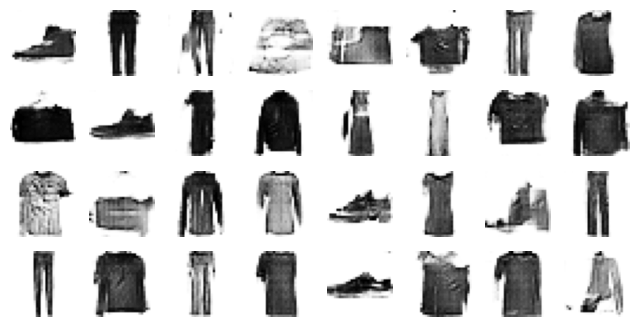

Epoch 7/10


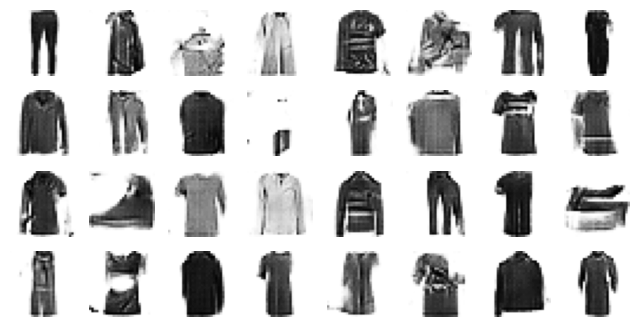

Epoch 8/10


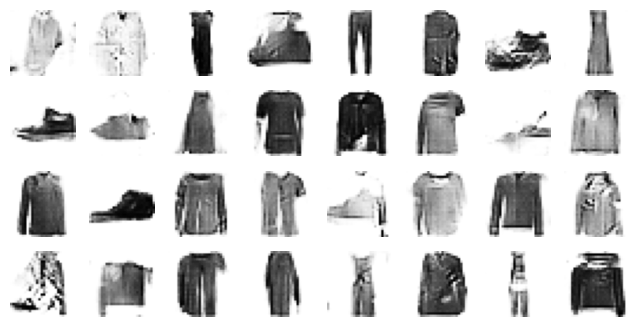

Epoch 9/10


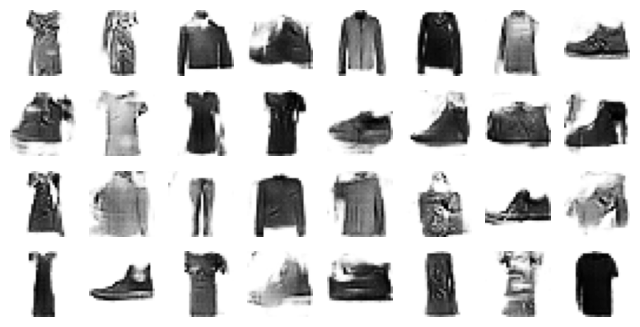

Epoch 10/10


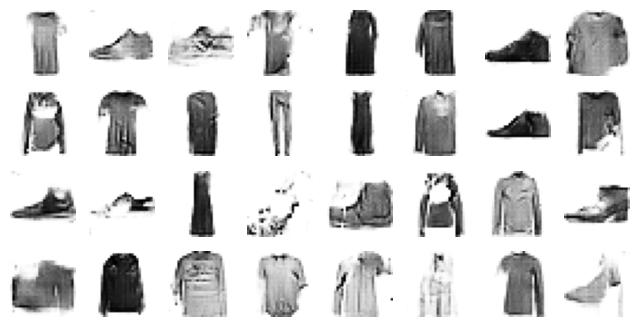

In [27]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=10)